In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

## Question 11

In [2]:
# Define Probability Function P_{SS'}^{a}
def probability(currS, nextS, move, prob):
    left = currS + actions[0]
    up = currS + actions[1]
    right = currS + actions[2]
    down = currS + actions[3]
    if nextS == left:
        if move == 0:
            return 1-prob+prob/4
        else:
            return prob/4
    elif nextS == up:
        if move == 1:
            return 1-prob+prob/4
        else:
            return prob/4
    elif nextS == right:
        if move == 2:
            return 1-prob+prob/4
        else:
            return prob/4
    elif nextS == down:
        if move == 3:
            return 1-prob+prob/4
        else:
            return prob/4
    elif nextS == currS:
        record = 0
        if left < 0:
            if move == 0:
                record += (1-prob+prob/4)
            else:
                record += prob/4
        if right > 99:
            if move == 2:
                record += (1-prob+prob/4)
            else:
                record += prob/4
        if up % 10 == 9:
            if move == 1:
                record += (1-prob+prob/4)
            else:
                record += prob/4
        if down % 10 == 0:
            if move == 3:
                record += (1-prob+prob/4)
            else:
                record += prob/4
        return record
    else:
        return 0

In [3]:
# Procedure Value Iteration
def compute(currS, move, prob, gamma, reward, values):
    left = currS + actions[0]
    right = currS + actions[2]
    up = currS + actions[1]
    down = currS + actions[3]
    neighbours = [left, right, up, down, currS]
    result = 0
    for neigh in neighbours:
        if neigh < 0 or neigh > 99 or (currS % 10 == 0 and neigh % 10 == 9) or (currS % 10 == 9 and neigh % 10 == 0):
            continue
        result += probability(currS, neigh, move, prob) * (reward[neigh] + gamma * values[neigh])
    return result


def optimal_state_val(values, w, gamma, reward, threshold):
    # 1) Initialization
    for state in range(100):
        values[state] = 0
    # 2) Estimation
    delta = float('inf')
    while delta > threshold:
        delta = 0
        temp = values[:]
        for state in range(100):
            v = values[state]
            values[state] = max(compute(state, 0, w, gamma, reward, temp),
                                compute(state, 1, w, gamma, reward, temp),
                                compute(state, 2, w, gamma, reward, temp),
                                compute(state, 3, w, gamma, reward, temp))
            delta = max(delta, abs(v - values[state]))
    return values

In [4]:
# get transition probabilities where all actions are same
def raw_matrix(length, w, direction):
    s = length * length
    res = np.zeros(s * s).reshape(s, s)
    main_possibility = 1 - w
    random_possibility = w / 4
    for row in range(s):
        nexts = next_states(length, row)
        if direction == "up":
            res[row][nexts[0]] = main_possibility
        elif direction == "down":
            res[row][nexts[1]] = main_possibility
        elif direction == "left":
            res[row][nexts[2]] = main_possibility
        elif direction == "right":
            res[row][nexts[3]] = main_possibility
        for col in nexts:
            res[row][col] += random_possibility
    return res
        
def next_states(length, cur_state):
    x = cur_state % length
    y = cur_state // length
    up = cur_state - 1
    down = cur_state + 1
    left = cur_state - length
    right = cur_state + length
    if x == 0:
        up = cur_state
    if x == length - 1:
        down = cur_state
    if y == 0:
        left = cur_state
    if y == length - 1:
        right = cur_state
    return np.array([up, down, left, right])

In [5]:
# get c, D, b arguments for solving LP later
def get_c_D_b(exp_action, P_actions, lam, rmax):
    # create P_exp(P_a1), P_ag1(P_a), P_ag2(P_a), P_ag3(P_a)
    P_exp = []
    P_ags = []
    P_ags.append([])
    P_ags.append([])
    P_ags.append([])
    for state in range(100):
        exp_act = exp_action[state]
        agent = 0
        for action in range(4):
            if action == exp_act:
                P_exp.append(P_actions[action][state])
            else:
                P_ags[agent].append(P_actions[action][state])
                agent += 1

    I = np.eye(100)
    zero = np.zeros(100 * 100).reshape(100, 100)
    D = np.concatenate((zero, zero, zero, zero))
    D = np.concatenate((D, np.concatenate((-I, -I, zero, zero)), 
                        np.concatenate((I, -I, I, -I))), 1)
 
    for Pa in P_ags:
        # (Pa-Pa1)(I-ga*Pa1)^(-1)
        temp = np.dot((np.array(Pa) - np.array(P_exp)), 
                      np.linalg.inv(np.eye(100) - 0.8 * np.array(P_exp)))
        temp_row1 = np.concatenate((I, zero, temp), 1)
        temp_row2 = np.concatenate((zero, zero, temp), 1)
        temp = np.concatenate((temp_row1, temp_row2))
        D = np.concatenate((temp, D))
        
    c1 = np.array([1. for _ in range(100)])
    c2 = np.array([-lam for _ in range(100)])
    c3 = np.array([0.0 for _ in range(100)])
    c = np.concatenate((c1, c2, c3), axis=0)
    c = -c
    b1 = np.array([0.0 for _ in range(800)])
    b2 = np.array([rmax for _ in range(200)])
    b = np.concatenate((b1, b2), axis=0)
    return c, D, b

In [6]:
# solve a LP to get reward
def get_reward(c, D, b):
    A = matrix(D)
    b = matrix(b)
    c = matrix(c)
    solvers.options['show_progress'] = False
    sol=solvers.lp(c,A,b)
    return sol['x'][-100:]

In [7]:
def sweep(exp_action, rmax):
    acc_list = []
    lam_list = []
    lam = 0
    for i in range(501):
        c, D, b = get_c_D_b(exp_action, P_acts, lam, rmax)
        reward = np.array(get_reward(c, D, b))
        value = optimal_state_val(values, w, gamma, reward, thres)
        # OA
        agent_action = [0 for _ in range(100)]
        for state in range(100):
            agent_action[state] = np.argmax([compute(state, 0, w, gamma, reward, value),
                                             compute(state, 1, w, gamma, reward, value),
                                             compute(state, 2, w, gamma, reward, value),
                                             compute(state, 3, w, gamma, reward, value)])
        count = 0
        for j, k in zip(exp_action, agent_action):
            if j == k:
                count += 1
        acc = count / len(agent_action)
        
        print("lambda: " + str(lam) + "  acc: " + str(acc))
        acc_list.append(acc)
        lam_list.append(lam)
        lam += 0.01
    return lam_list, acc_list

lambda: 0  acc: 0.82
lambda: 0.01  acc: 0.81
lambda: 0.02  acc: 0.81
lambda: 0.03  acc: 0.81
lambda: 0.04  acc: 0.81
lambda: 0.05  acc: 0.81
lambda: 0.060000000000000005  acc: 0.73
lambda: 0.07  acc: 0.73
lambda: 0.08  acc: 0.73
lambda: 0.09  acc: 0.73
lambda: 0.09999999999999999  acc: 0.73
lambda: 0.10999999999999999  acc: 0.73
lambda: 0.11999999999999998  acc: 0.73
lambda: 0.12999999999999998  acc: 0.73
lambda: 0.13999999999999999  acc: 0.73
lambda: 0.15  acc: 0.73
lambda: 0.16  acc: 0.73
lambda: 0.17  acc: 0.73
lambda: 0.18000000000000002  acc: 0.73
lambda: 0.19000000000000003  acc: 0.74
lambda: 0.20000000000000004  acc: 0.72
lambda: 0.21000000000000005  acc: 0.72
lambda: 0.22000000000000006  acc: 0.73
lambda: 0.23000000000000007  acc: 0.73
lambda: 0.24000000000000007  acc: 0.73
lambda: 0.25000000000000006  acc: 0.73
lambda: 0.26000000000000006  acc: 0.73
lambda: 0.2700000000000001  acc: 0.73
lambda: 0.2800000000000001  acc: 0.73
lambda: 0.2900000000000001  acc: 0.73
lambda: 0.30000

lambda: 2.2199999999999966  acc: 0.92
lambda: 2.2299999999999964  acc: 0.93
lambda: 2.239999999999996  acc: 0.92
lambda: 2.249999999999996  acc: 0.92
lambda: 2.259999999999996  acc: 0.92
lambda: 2.2699999999999956  acc: 0.92
lambda: 2.2799999999999954  acc: 0.92
lambda: 2.289999999999995  acc: 0.92
lambda: 2.299999999999995  acc: 0.92
lambda: 2.3099999999999947  acc: 0.92
lambda: 2.3199999999999945  acc: 0.92
lambda: 2.3299999999999943  acc: 0.93
lambda: 2.339999999999994  acc: 0.92
lambda: 2.349999999999994  acc: 0.92
lambda: 2.3599999999999937  acc: 0.92
lambda: 2.3699999999999934  acc: 0.92
lambda: 2.3799999999999932  acc: 0.92
lambda: 2.389999999999993  acc: 0.92
lambda: 2.399999999999993  acc: 0.92
lambda: 2.4099999999999926  acc: 0.92
lambda: 2.4199999999999924  acc: 0.92
lambda: 2.429999999999992  acc: 0.92
lambda: 2.439999999999992  acc: 0.92
lambda: 2.4499999999999917  acc: 0.92
lambda: 2.4599999999999915  acc: 0.92
lambda: 2.4699999999999913  acc: 0.92
lambda: 2.4799999999999

lambda: 4.41999999999995  acc: 0.9
lambda: 4.42999999999995  acc: 0.9
lambda: 4.43999999999995  acc: 0.91
lambda: 4.4499999999999496  acc: 0.9
lambda: 4.459999999999949  acc: 0.91
lambda: 4.469999999999949  acc: 0.91
lambda: 4.479999999999949  acc: 0.91
lambda: 4.489999999999949  acc: 0.91
lambda: 4.4999999999999485  acc: 0.9
lambda: 4.509999999999948  acc: 0.91
lambda: 4.519999999999948  acc: 0.91
lambda: 4.529999999999948  acc: 0.92
lambda: 4.539999999999948  acc: 0.92
lambda: 4.549999999999947  acc: 0.91
lambda: 4.559999999999947  acc: 0.92
lambda: 4.569999999999947  acc: 0.92
lambda: 4.579999999999947  acc: 0.92
lambda: 4.589999999999947  acc: 0.92
lambda: 4.599999999999946  acc: 0.92
lambda: 4.609999999999946  acc: 0.92
lambda: 4.619999999999946  acc: 0.91
lambda: 4.629999999999946  acc: 0.92
lambda: 4.6399999999999455  acc: 0.92
lambda: 4.649999999999945  acc: 0.92
lambda: 4.659999999999945  acc: 0.92
lambda: 4.669999999999945  acc: 0.92
lambda: 4.679999999999945  acc: 0.91
lambd

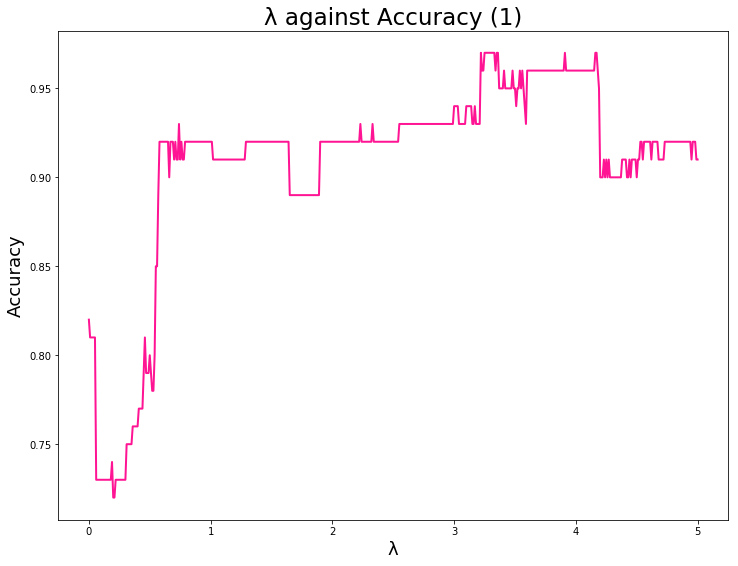

In [9]:
# Create Environment of the Agent
values = [0 for _ in range(100)]
thres = 0.01
actions = [-10, -1, 10, 1] # left, up, right, down
w = 0.1
gamma = 0.8

# record expert actions
reward1 = [[0 for _ in range(10)] for _ in range(10)]
reward1[9][9] = 1
reward_1 = []
reward1 = np.array(reward1).transpose()
for lines in reward1:
    reward_1 += list(lines)
exp_action = [0 for _ in range(100)]
values = optimal_state_val(values, w, gamma, reward_1, thres)
for state in range(100):
    exp_action[state] = np.argmax([compute(state, 0, w, gamma, reward_1, values),
                                   compute(state, 1, w, gamma, reward_1, values),
                                   compute(state, 2, w, gamma, reward_1, values),
                                   compute(state, 3, w, gamma, reward_1, values)])

P_acts = []
P_acts.append(raw_matrix(10, 0.1, "left"))
P_acts.append(raw_matrix(10, 0.1, "up"))
P_acts.append(raw_matrix(10, 0.1, "right"))
P_acts.append(raw_matrix(10, 0.1, "down"))

lam_list, acc_list = sweep(exp_action, 1.0)

# plot figure
plt.figure(figsize=(12,9))
plt.xlabel('λ', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.title('λ against Accuracy (1)', fontsize=23)
plt.plot(lam_list, acc_list, color="deeppink", lw=2)
plt.show()

## Question 12

In [10]:
max_index = np.argmax(acc_list)
lam_max = lam_list[max_index]
print(lam_max)

3.2199999999999753
